### Настройки и импорты

Модуль содержит импорты всех необходимых библиотек и настройки ноутбука для отображения датафреймов и графиков.

In [13]:
# Для запуска в google.colab

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

# !pip install catboost
# !pip install h2o

# PATH = '/content/drive/MyDrive/Colab Notebooks/madwagon/data'
# %matplotlib inline

In [8]:
PATH = './madwagon/data'

In [9]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tabulate
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import h2o
from h2o.estimators import H2OXGBoostEstimator
from h2o.automl import H2OAutoML

## for the LSTM module
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [10]:
t0 = datetime.datetime.now()
print(f't0 = {t0.strftime("%H:%M:%S")}')

t0 = 16:33:44


In [11]:
sns.set(rc={'figure.figsize':(12.7,10.27)})
# sns.set(rc={'figure.figsize':(11.7, 8.27)})

In [12]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

### Загрузка данных

Загрузка следующих данных:  
1) *statistics-07-20.csv* - изначально представленные данные  
2) *ssp_stat_load_car-94-96.csv* - более актуальные данные с операциями отправления по вагонам  
3) *poezd.csv* - справочник по операциям с поездами  
4) *codes.csv* - справочник по операциям с вагонами  
5) *RZD.csv* - датасет расширенный данными по геолокации

In [14]:
# Загрузка данных
df = pd.read_csv(f'{PATH}/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
new_data = pd.read_csv(f'{PATH}/ssp_stat_load_car-94-96.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv(f'{PATH}/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv(f'{PATH}/codes.csv',sep=';', encoding='utf-8')
edf = pd.read_csv(f'{PATH}/RZD.csv', sep='\t', encoding='utf-8')

In [15]:
# Датасет отсортированный по станции > номеру вагона > времени операции
# ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

# Датасет из свежих данных от 21/05/21
ndf = new_data.copy().sort_values(by=['operation_date'])

### Анализ датасета

#### Справочные функции

In [16]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(operation_code):
    try:
        v = f'По вагону: {car_ops[car_ops.index_code == operation_code].values[0]}'
    except:
        v = 'NOP'
    try:
        p = f'По поезду: {train_ops[train_ops.index_code == operation_code].values[0]}'
    except:
        p = 'NOP'
    
    return [v,p]
    
get_op_info(3)

["По вагону: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']",
 "По поезду: [3 'Пс' 'Просл. поездом станции без остановки (без приема/сдачи)']"]

In [17]:
def extract_train(index_train):
    lst = []
    for i,j in enumerate(str(index_train)):
        lst.append(j)
        i+=1
    print('Единая Сетевая Разметка, ЕСР:', ''.join(lst[0:6]))
    print('Порядковый номер состава:', ''.join(lst[6:9]))
    print('ЕСР железнодорожной станции назначения поезда:', ''.join(lst[9:16]))

In [18]:
def extract_car(car_number):
    lst = []
    for i,j in enumerate(str(car_number)):
        if i == 0 and j == '2':
            lst.append('крытый')
        elif i == 0 and j == '3':
            lst.append('специальный вагон (к примеру, четырехосный думпкар, хоппер-дозатор, транспортер)')
        elif i == 0 and j == '4':
            lst.append('платформы')
        elif i == 0 and j == '5':
            lst.append('означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»')
        elif i == 0 and j == '6':
            lst.append('полувагон')
        elif i == 0 and j == '7':
            lst.append('цистерны')
        elif i == 0 and j == '8':
            lst.append('изотермические')
        elif i == 0 and j == '9':
            lst.append('прочие')
        elif i == 1 and j == '2':
            lst.append('двух осный')
        elif i == 1 and j == '4':
            lst.append('четырех осный')
        elif i == 1 and j == '6':
            lst.append('шести осный')
        elif i == 1 and j == '8':
            lst.append('восьми осный')
        elif i == 1 and j == '12':
            lst.append('двенадцати осный')
        elif i == 1 and j == '16':
            lst.append('шестнадцати осный')
        elif i == 2 and j == '5':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '6':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '7':
            lst.append('четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М')
        elif i == 2 and j == '8':
            lst.append('цистерна с объемом котла 75 м3')
        elif i == 2 and j == '9':
            lst.append('цистерна с объемом котла 85,6 м3')
        elif i == 3 and j.isdigit():
            lst.append('номер вагона который был присвоен заводом: {}'.format(j))
        elif i == 4 and j.isdigit():
            lst.append(j)
        elif i == 5 and j.isdigit():
            lst.append(j)
        elif i == 6 and j.isdigit():
            lst.append('имеется ручной тормоз или переходная площадка, код: {}'.format(j))
        elif i == 7 and j.isdigit():
            lst.append('контрольное число вагона: {}'.format(j))
        else:
            continue
            
    print(f'Вагон {car_num} был отмечен на следующих станциях:\n')
    for i in ndf.operation_st_esr[ndf.car_number == car_num].unique(): print(i)

    print(f'\nВагон {car_num} был отмечен в следующих поездах:\n')
    for i in ndf.index_train[ndf.car_number == car_num].unique(): 
        if np.isnan(i): 
            continue
        else:
            print(int(i))
    print(f'\nСвойства:\n{lst}')

In [19]:
extract_train(954704366955406)

Единая Сетевая Разметка, ЕСР: 954704
Порядковый номер состава: 366
ЕСР железнодорожной станции назначения поезда: 955406


In [20]:
# extract_car(67062638)

#### Параметры датасета

<AxesSubplot:>

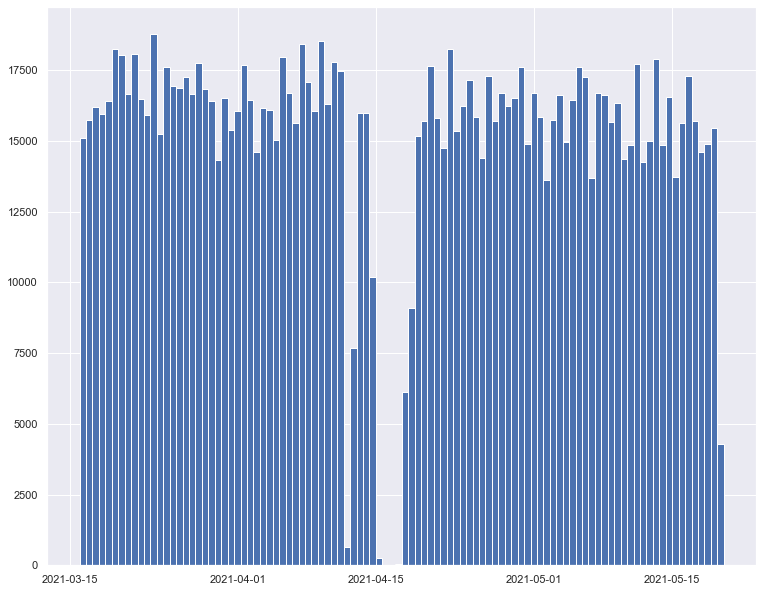

In [21]:
"""
[Комментарии]
  Ниже видно, что в исходных данных есть провал. Примерно с 15 по 18 апреля данные отсутствуют. 
  Возможно данные так были выгружены, или по какой-то причине отсутствуют в системе.
"""
ndf.operation_date.hist(bins=100,)

In [22]:
print(f'Размерность датасета: {ndf.shape}\n')
print(f'Временной диапазон:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}\n')

print(f'Уникальных станций: {ndf.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {ndf.car_number.nunique()}\n')

# print(f'Количество вагонов которые были отправлены хотя бы один раз:\
#  {ndf.car_number[ndf.operation_car == 2].nunique()}')
# print(f'В датасете нет данных об отправке\
#  {ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} уникальных вагонов')

print(f'Уникальных операций с вагонами: {ndf.operation_car[ndf.operation_car.notnull()].nunique()}')
print(f"Уникальных операций с поездами: {ndf.operation_train[ndf.operation_train.notnull()].nunique()}")

Размерность датасета: (1501134, 44)

Временной диапазон:
min: 2021-03-16 00:01:00
max: 2021-05-20 05:51:00

Уникальных станций: 141
Уникальных вагонов: 119768

Уникальных операций с вагонами: 18
Уникальных операций с поездами: 13


In [23]:
ndf.operation_car[ndf.operation_car.notnull()].nunique()

18

In [24]:
print('Уникальных операций с вагонами в датасете:')
for i in ndf.operation_car[ndf.operation_car.notnull()].value_counts().index:
    print(i,car_ops.description[car_ops.index_code == i].values)

Уникальных операций с вагонами в датасете:
4 ['ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
3 ['ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
81 ['УБОРКА ВАГОНА С ПП                    ']
80 [' ПОДАЧА ВАГОНА НА ПП                  ']
2 ['ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
21 ['ВЫГРУЗКА НА ПП                        ']
8 ['ПРИБЫТИЕ ВАГОНА НА СТАНЦИЮ            ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
79 [' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
78 [' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
30 ['ЗАНЯТИЕ ПРИ СОРТ. МЕЛКИХ ОТП. И КОНТ. ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
40 ['ОСВОБ. ПРИ СОРТ.МЕЛК.ОТПРАВОК И КОНТ. ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']


In [25]:
print('Уникальных операций с поездами в датасете:')
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

Уникальных операций с поездами в датасете:
5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
1.0 ['Приб. поезда на станцию (без приема на дорогу, отделение, участок ДНЦ)']
72.0 ['Отцепка вагонов']
71.0 ['Прицепка вагонов']
51.0 ['Приб. поезда на станцию с приемом на участок ДНЦ']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
44.0 ['Подача маршрута под грузовые операции']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
11.0 ['Приб. поезда с приемом на дорогу, из-за границы или новостройки']
35.0 ['Образование соединенного поезда']


#### Переменные st_id и car_num

In [26]:
## В этой ячейке задаются переменные st_id - ЕСР станции, car_num - номер вагона.
## Задавая значения переменным можно проводить визуальный анализ по определенной станции или вагону.

"""
Примеры номеров станций ['operation_st_esr']
"""
# st_id = 889505 # 100 ops, 4 cars
# st_id = 845009 # 90 ops, 28 cars
# st_id = 977000 # 50 ops, 10 cars
# st_id = 985906 # 207037 ops, 43702 cars
# st_id = 925701 # 37386 ops, 3801 cars
# st_id = 926206 # 18489 ops, 363 cars
# st_id = 880407
# st_id = 967704 # станция с аномальными данными - таможенный пост Морской порт Ванино 
# st_id = 881804
# st_id = 986103 # top-1 by dest # НАХОДКА-ВОСТОЧНАЯ (ЭКСП.) https://www.logistics1520.com/railway/station/98610-nahodka-vostochnaya-eksp/
# st_id = 863007 # 5th by destination
# st_id = 950101
# st_id = 954704
st_id = 968707 # Дземги - https://www.logistics1520.com/railway/station/96870-dzemgi/


"""
Примеры номеров вагонов ['car_number']
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310
# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
# car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
# car_num = 55864821
# car_num = 62236872
# car_num = 30860712
# car_num = 30870752
# car_num = 42051359
# car_num = 42780155
# car_num = 30061394
# car_num = 55952550
# car_num = 67062638 ## вагон с наглядым графом перехода состояний
# car_num = 53447488
car_num = 54643101

"""
Примеры номеров поездов ['index_train']
"""
train_num = 954704366955406

#######################

# проверка соответствия st_id и car_num
def check_st_car(st_id, car_num):
    if ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0] == 0:
        print(f'Для станции {st_id} нет записей с вагоном {car_num}')
        print(f'\nТоп 10 вагонов по количеству записей для станции:\n')
        print(
            pd.DataFrame(
                {'Вагон': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().index[:10],
                 'Строк': ndf.car_number[ndf.operation_st_esr == st_id].value_counts().values[:10]}
            )

        )
        print(f'\nС вагоном {car_num} есть записи на следующих станциях:\n')
        print(
            pd.DataFrame(
                {'Станция': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().index,
                 'Строк': ndf.operation_st_esr[ndf.car_number == car_num].value_counts().values}
            )
        )

    else:
        print(
            f'Для станции {st_id} есть \
{ndf.operation_st_esr[ndf.car_number == car_num][ndf.operation_st_esr == st_id].shape[0]} \
строк(а) по вагону {car_num}'
        )


check_st_car(st_id, car_num)
print(f'\nВагон {car_num} также присутствует в записях со следующими поездами: \n\n\
{ndf.index_train[ndf.car_number == car_num].value_counts()}')

Для станции 968707 есть 50 строк(а) по вагону 54643101

Вагон 54643101 также присутствует в записях со следующими поездами: 

960007553968707.00    3
968707424960007.00    3
968707331960103.00    2
968707262960007.00    2
960007509968707.00    2
960007363968707.00    2
968707287960103.00    2
968707393960007.00    2
968707543960103.00    2
960007436970001.00    2
960007538968707.00    1
960007464968707.00    1
985906018968707.00    1
Name: index_train, dtype: int64


#### Визуализация датасета

In [27]:
print(f'Для визуализации используются следующие переменные:\n\nst_id \t= {st_id}\ncar_num = {car_num}\n')
print(f'В датасете по станции {st_id} имеются записи по:\n\n{ndf.car_number[ndf.operation_st_esr == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_esr == st_id].shape[0]} операциям\n')
extract_car(car_num)

Для визуализации используются следующие переменные:

st_id 	= 968707
car_num = 54643101

В датасете по станции 968707 имеются записи по:

10670 вагонам и
141749 операциям

Вагон 54643101 был отмечен на следующих станциях:

968707
960007

Вагон 54643101 был отмечен в следующих поездах:

960007363968707
968707262960007
985906018968707
968707287960103
960007436970001
960007464968707
968707331960103
960007509968707
968707393960007
960007538968707
968707424960007
960007553968707
968707543960103

Свойства:
['означает, что вагон отнесен к группе собственных грузовых вагонов и не входит в состав парка ОАО «РЖД»', 'четырех осный', 'четырехосного хоппера-дозатора типа ЦНИИ-ДВ3М', 'номер вагона который был присвоен заводом: 4', '3', '1', 'имеется ручной тормоз или переходная площадка, код: 0', 'контрольное число вагона: 1']


#### Анализ количества операций на станции по вагонам

Displaing first 800 operations out of 141749:


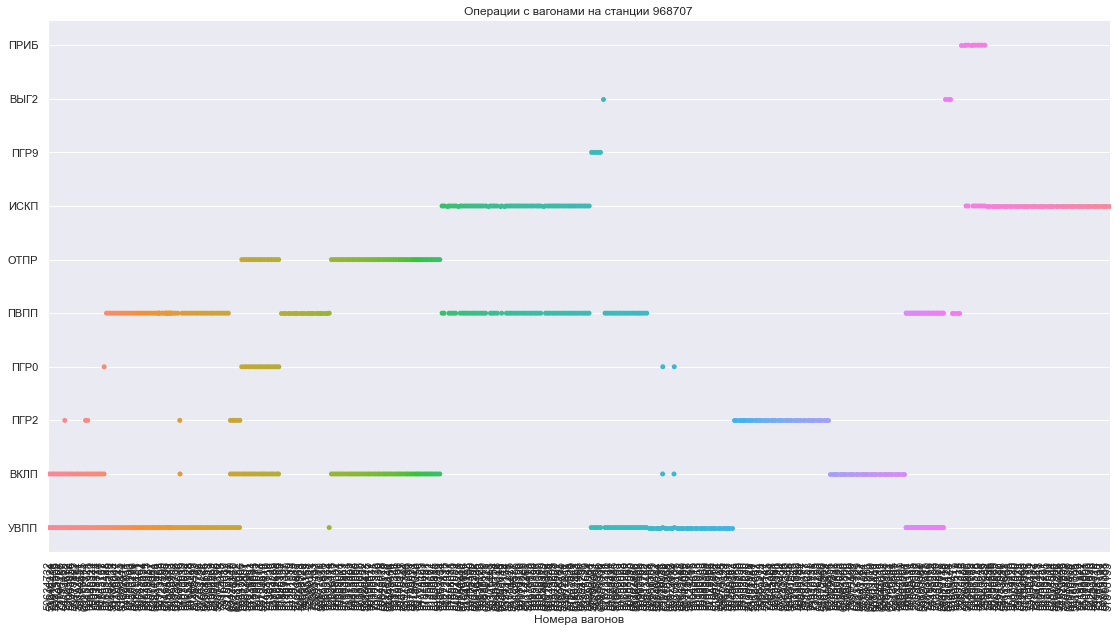

In [28]:
"""
[Коментарии]
  На графике ниже можно видеть количество и частоту операций с вагонами
  по станции заданной в переменной st_id
"""

tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
tmp_df = tmp_df[['car_number','operation_car']]
tmp_df.car_number = tmp_df.car_number.apply(lambda x: str(x))
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

if tmp_df.shape[0] > 800:
    print(f"Displaing first 800 operations out of {tmp_df.shape[0]}:")
    tmp_df = tmp_df.loc[:800]


sns.catplot(x=tmp_df['car_number'], y=tmp_df['operation_car'],data=tmp_df,height=8, aspect=4/2)
plt.ylabel('')
plt.xlabel('Номера вагонов')
plt.xticks(rotation=90)
# plt.minorticks_on()
plt.grid(which='minor')
plt.title(f'Операции с вагонами на станции {st_id}')
plt.show()
# del(tmp_df)

#### Анализ количества операций на станции по времени операции

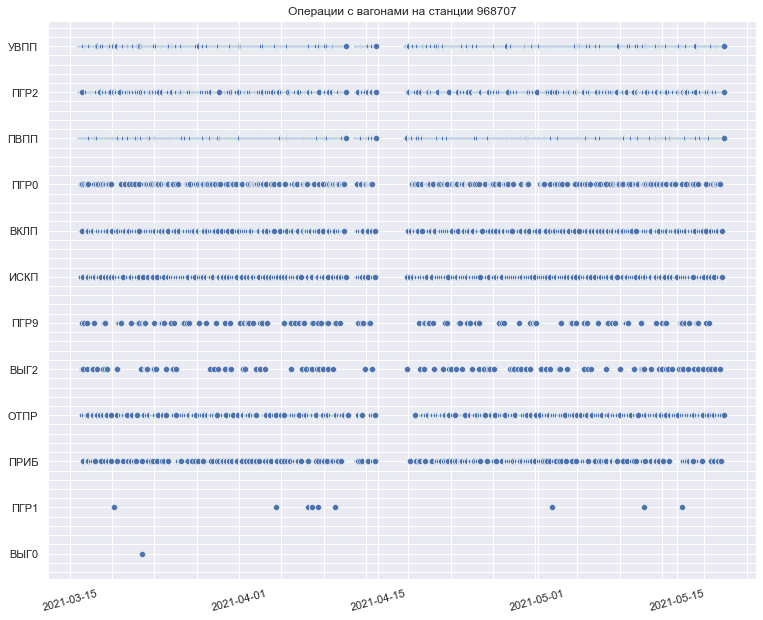

In [29]:
"""
[Коментарии]
  На этом графике видно распределение типов операций по времени на станции,
  заданной в переменной st_id
"""
warnings.filterwarnings('ignore')

tmp_df = ndf[ndf.operation_st_esr == st_id].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагонами на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Анализ операций с вагоном на станции по времени

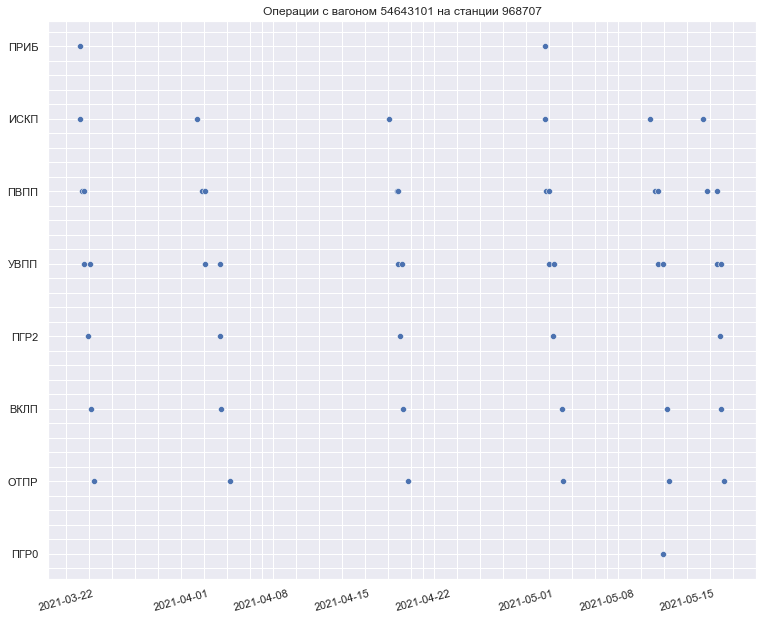

In [30]:
"""
[Коментарии]
  На этом графике распределение по времени операций с вагоном заданным
  в переменной car_num на станции st_id
"""
# warnings.filterwarnings('ignore')
tmp_df = ndf[ndf.operation_st_esr == st_id][ndf.car_number == car_num].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагоном {car_num} на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Граф последовательностей операций и количества переходов

In [31]:
def count_ops_transitions(car: int) -> dict:
    """
    Функция строит словарь с уникальными переходами по операциям с вагоном и количеством таких переходов.
    :param car: Номер вагона
    :return: Словарь с уникальными переходами по операциям и их количеством. 
    Пример словаря: {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
        
    opsListCart = list(ndf[ndf.car_number == car].sort_values(by=['operation_date'])['operation_car'])
    sChangeDF = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
    
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

Граф переходов между операциями с вагоном 54643101:



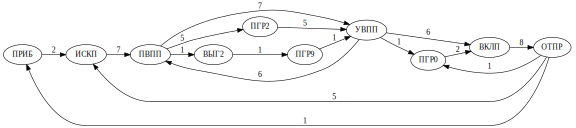

In [32]:
"""
[Коментарии]
  На графе отображается количество переходов между операциями с вагоном
  заданным в переменной car_num.
"""

sdict = count_ops_transitions(car_num)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

# DG.view() # экспорт в pdf
print(f'Граф переходов между операциями с вагоном {car_num}:\n')
DG

#### Граф последовательностей операций с вагоном с указанием времени между операциями

Граф переходов между операциями с вагоном 54643101:



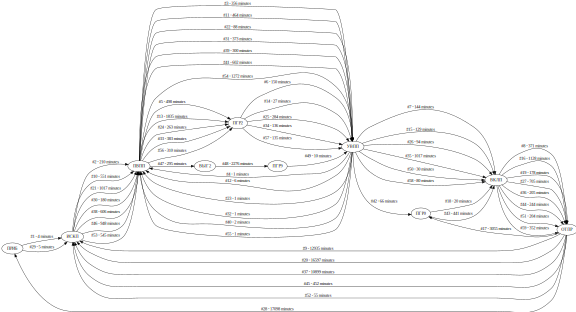

In [33]:
"""
[Коментарии]
  На графе отображаются переходы между операциями с вагоном заданным
  в переменной car_num, и указывается время между операциями.
"""

# timedelta64[m] - в минутах
# timedelta64[h] - в часах

cops = ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])['operation_car'].index
DG = Digraph(f'FSM for car #{car_num}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[m]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


# DG.view() # экспорт в pdf
print(f'Граф переходов между операциями с вагоном {car_num}:\n')
DG # отобразить граф в ячейке

#### Анализ цепочек операций

В данном модуле мы анализировали цепочки операций с вагонами. Можно отметить что некоторые последовательности операций повторяются, а также некоторые вагоны можно сгруппировать по последовательностям операций которые с ними выполняются.

In [34]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_esr == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_esr == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

def sort_dict(dct: dict) -> dict:
    '''
    Сортирует цепочки операций
    '''
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

def agg_by_car(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [35]:
"""
[Коментарии]
  Здесь происходит выборка последовательностей операций по вагонам на станции заданной в st_id
"""
cars_ops = sort_dict(extract_ops_chains(st_id))
cars_ops

100%|██████████| 10670/10670 [02:23<00:00, 74.50it/s]


{70723119: '81 81 80 11 81',
 73001315: '81 80 81 80 81 80 11 81  4  4  2',
 51020733: '81 80 81 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 50915263: '81 80 81 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 51454395: '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 81 80 11 81  4  2',
 50933399: '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 11 81  4  2',
 73032161: '81 80 81 80 81 80 11 81  4  2',
 50938208: '81 80 81 80 81  4  2  3 80 81 80 81 18  4  2',
 51999753: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 50965953: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 54884978: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 56727795: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 54723465: '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2',
 75033712: '81 80 81 80 11 81  4 81  4',
 54080718: '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 

In [36]:
"""
[Коментарии]
  Здесь цепочки операций аггрегируются по номерам вагонов по станции заданной в st_id
"""
agg_by_car(cars_ops)

{'81 81 80 11 81': [70723119],
 '81 80 81 80 81 80 11 81  4  4  2': [73001315],
 '81 80 81 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [51020733, 50915263],
 '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 81 80 11 81  4  2': [51454395],
 '81 80 81 80 81 80 11 81  4  2  3 80 11  4  2  3 80 81 80 11 81  4  2': [50933399],
 '81 80 81 80 81 80 11 81  4  2': [73032161],
 '81 80 81 80 81  4  2  3 80 81 80 81 18  4  2': [50938208],
 '81 80 81 80 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [51999753,
  50965953,
  54884978,
  56727795,
  54723465],
 '81 80 81 80 11 81  4 81  4': [75033712],
 '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 80 81 80 11 81  4  2  8  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [54080718],
 '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 80 81 80 11 81  4  2  8  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': [75039867,
  57191066,
  73003410,
  57595381],
 '81 80 81 80 11 81  4  2  8  3 80 11  4  2  3 80 81 80

In [37]:
"""
[Коментарии]
  Здесь подсчитывается количество вагонов над которыми были выполнены
  совпадающие последовательности операций
"""

ocl = agg_by_car(cars_ops)
for key in ocl:
    ocl[key] = len(ocl[key])
ocl = sort_dict(ocl)
ocl

{'3 80 81 80 11 81  4  2': 961,
 '3 80 11 81  4  2': 724,
 '8  3 80 81 80 11 81  4  2': 319,
 '8  3 80 11 81  4  2': 266,
 '3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': 224,
 '3 80': 166,
 '3 80 11 81  4  2  3 80 11 81  4  2': 146,
 '3': 117,
 '11 81  4  2': 91,
 '8  3 80 11 81  4  2  3 80 11 81  4  2': 84,
 '3 80 81 80 11 81': 78,
 '3 80 81 80 11 81  4  3 80 81 80 11 81  4  2': 76,
 '8  3 80 81 80 11 81': 71,
 '3 80 81 80 11 81  4  2  8  3 80 81 80 11 81  4  2': 71,
 '3 80 11 81  4  2  8  3 80 11 81  4  2': 71,
 '3 80 81 80 81 18  4  2': 65,
 '8  3 80 81 80 11 81  4  2  3 80 81 80 11 81  4  2': 64,
 '8  3 80': 62,
 '3 80 11 81  4  2  3 80 11 81  4  2  3 80 11 81  4  2': 61,
 '3 80 11 81': 54,
 '3 80 11  4  2': 50,
 '3 80 81  4  2': 47,
 '80 81 80 11 81  4  2': 44,
 '3 81 80 11 81  4  2': 44,
 '3 80 81 80 19 81  4  2': 42,
 '3 80 80 11 81  4  2': 40,
 '80 11 81  4  2': 39,
 '3 80 11 81  4  2  3 80 11 81  4  2  8  3 80 11 81  4  2': 39,
 '8  3 80 81 80 11 81  4  2  8  3 80 81 80 11 

In [38]:
# цепочка операций для вагона car_num
# ops = list(ndf.operation_car[ndf.car_number == car_num].values)

ops = list(ocl.keys())[0]
ops = list(map(float, ops.split()))
print(f'Самая повторяющаяся цепочка операций на станции {st_id}:\n{ops}')

Самая повторяющаяся цепочка операций на станции 968707:
[3.0, 80.0, 81.0, 80.0, 11.0, 81.0, 4.0, 2.0]


In [39]:
# описание цепочки операций ops
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
[11 'ПГР2' 'ПОГРУЗКА НА ПП                        ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']


### Формирование датасета для обучения моделей

In [40]:
tst = ndf[ndf.operation_date < '2021-03-16 23:59:59']
tst = tst[tst.operation_date > '2021-03-15 23:59:59']

In [41]:
'''
Выборка операций погрузки/разгрузки
21 ['ВЫГРУЗКА НА ПП                        ']
19 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
11 ['ПОГРУЗКА НА ПП                        ']
18 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
20 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
10 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
28 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
29 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']
'''
ops = [21, 19, 11, 18, 20, 10, 28, 29]

#### Промежуточный датасет с историей операций относительно operation_car

В этом модуле создается датасет в котором для каждой интересующей операции добавляется информация по четырем прошлым операциям и дельте времени между ними и текущей и по одной следующей операции и дельте времени между ней и текущей.

In [42]:
def build_df_for_train(df,ops):

    ## выбрать индексы нужных операций
    ops_index = pd.core.indexes.numeric.Int64Index([],dtype='int64')
    for op in ops:        
        ops_index = ops_index.append(df[df.operation_car == op].index)
    
    ## по индексам формируем словари с фичами
    ops_dict,times_dict,future_dict = dict.fromkeys(ops_index),dict.fromkeys(ops_index),dict.fromkeys(ops_index)
    for index in tqdm(ops_index):

        car_num = df.car_number[df.index == index].values[0]
        time_op = df.operation_date[df.index == index].values[0]

        temp_df = df[df.car_number == car_num].copy()
        
        temp_df = temp_df.sort_values(by=['operation_date'])
        
        temp_df_future = temp_df[temp_df.operation_date > time_op]
        
        
        try:
            f1 = temp_df_future.operation_car.values[0]
            f2 = temp_df_future.operation_date.values[0] - time_op
            
        except:
            f1 = np.nan
            f2 = np.datetime64('')

        future = [f1,f2.astype('timedelta64[m]')]
        
        temp_df_past = temp_df[temp_df.operation_date <= time_op]
        temp_df_past = temp_df_past.drop(index,axis='index')

        times_list = time_op - temp_df_past.operation_date[-4:].iloc[::-1].values
        ops_list = temp_df_past.operation_car[-4:].iloc[::-1].values

        # to flip indexes .iloc[::-1]

        future_dict[index] = future
        times_dict[index] = times_list
        ops_dict[index] = ops_list
    
    ## конвертируем словари в pandas df
    df1 = pd.DataFrame.from_dict(times_dict,orient='index',columns=['minus1_timedelta','minus2_timedelta','minus3_timedelta','minus4_timedelta'])
    df2 = pd.DataFrame.from_dict(ops_dict,orient='index',columns=['minus1_op','minus2_op','minus3_op','minus4_op'])
    df3 = pd.DataFrame.from_dict(future_dict,orient='index',columns=['future_op','future_op_timedelta'])
    
    return pd.concat([df3,df.loc[ops_index],df2, df1], axis=1)

In [43]:
## посторить датасет zzz из датасета tst по списку операций ops (см выше)
zzz = build_df_for_train(tst,ops)
zzz

100%|██████████| 5164/5164 [00:15<00:00, 332.36it/s]


,future_op,future_op_timedelta,adm,car_number,danger,...,minus4_op,minus1_timedelta,minus2_timedelta,minus3_timedelta,minus4_timedelta
13934,NaN,NaT,26,75003517,1.00,...,NaN,NaT,NaT,NaT,NaT
3896,81.00,0 days 02:45:00,27,54085923,1.00,...,NaN,NaT,NaT,NaT,NaT
3861,81.00,0 days 02:45:00,20,53992103,1.00,...,NaN,NaT,NaT,NaT,NaT
1710,81.00,0 days 02:45:00,20,50215490,1.00,...,NaN,NaT,NaT,NaT,NaT
4096,81.00,0 days 02:45:00,20,54756671,1.00,...,NaN,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
14280,81.00,0 days 00:27:00,20,94507753,NaN,...,NaN,NaT,NaT,NaT,NaT
6499,4.00,0 days 02:24:00,20,60366457,NaN,...,NaN,NaT,NaT,NaT,NaT
6189,4.00,0 days 02:24:00,20,60387222,NaN,...,NaN,NaT,NaT,NaT,NaT
7789,4.00,0 days 02:24:00,20,61526976,NaN,...,NaN,NaT,NaT,NaT,NaT


In [44]:
zzz

,future_op,future_op_timedelta,adm,car_number,danger,...,minus4_op,minus1_timedelta,minus2_timedelta,minus3_timedelta,minus4_timedelta
13934,NaN,NaT,26,75003517,1.00,...,NaN,NaT,NaT,NaT,NaT
3896,81.00,0 days 02:45:00,27,54085923,1.00,...,NaN,NaT,NaT,NaT,NaT
3861,81.00,0 days 02:45:00,20,53992103,1.00,...,NaN,NaT,NaT,NaT,NaT
1710,81.00,0 days 02:45:00,20,50215490,1.00,...,NaN,NaT,NaT,NaT,NaT
4096,81.00,0 days 02:45:00,20,54756671,1.00,...,NaN,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
14280,81.00,0 days 00:27:00,20,94507753,NaN,...,NaN,NaT,NaT,NaT,NaT
6499,4.00,0 days 02:24:00,20,60366457,NaN,...,NaN,NaT,NaT,NaT,NaT
6189,4.00,0 days 02:24:00,20,60387222,NaN,...,NaN,NaT,NaT,NaT,NaT
7789,4.00,0 days 02:24:00,20,61526976,NaN,...,NaN,NaT,NaT,NaT,NaT


#### Выборка индексов операций ОТПР удовлетворяющих условиям:  "погрузка/разгрузка" -> "включение в поезд" -> "отправление"

In [45]:
"""
Проверяется факт погрузки/разгрузки, затем ищем операцию отправления и если предыдущия операция 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД',
запоминаем индекс станции отправления.
"""

def get_list_of_indexes_with_success(df, cars):
    x = []

    for car in tqdm(cars):
#         print(f'\n\t{car}')

        ops_with_car_df = df[df.car_number == car].sort_values(by=['operation_date'])['operation_car']

        for cycle, i in enumerate(ops_with_car_df.index):
#             print(df.loc[i]['operation_car'])  ## for debug
            if df.loc[i]['operation_car'] in ops:
                load_unload = df.loc[i]['operation_st_esr']
            if df.loc[i]['operation_car'] == 2:
                if df.loc[ops_with_car_df.index[cycle - 1]]['operation_car'] == 4:
                    if load_unload == df.loc[i]['operation_st_esr']:
#                         print(df.loc[i]['index_train'])
#                         print(df.loc[i]['operation_date'])   
#                         print(df.loc[ops_with_car_df.index[cycle - 1]]['operation_date'])
#                         print('reset load state')
                        x.append(i)
                        load_unload = False
                else:
#                     print('reset load state')
                    load_unload = False
        
    return x

* Собираются индексы всех интересующих нас операций отправления.
* Создается датафрейм со столбцом 'target' в котором собранные индексы помечаются единицей

In [46]:
x = get_list_of_indexes_with_success(ndf, ndf.car_number.unique())

100%|██████████| 119768/119768 [16:53<00:00, 118.21it/s]


In [47]:
# # экспорт списка индексов для загрузки на GitHub
# with open('selected_ops.txt', 'w') as f:
#     for item in x:
#         f.write("%s\n" % item)

In [48]:
# новый столбец с таргетом
dff = ndf.assign(target=pd.Series(dtype=int))
# помечаем все найденные индексы 
dff['target'].loc[x] = 1

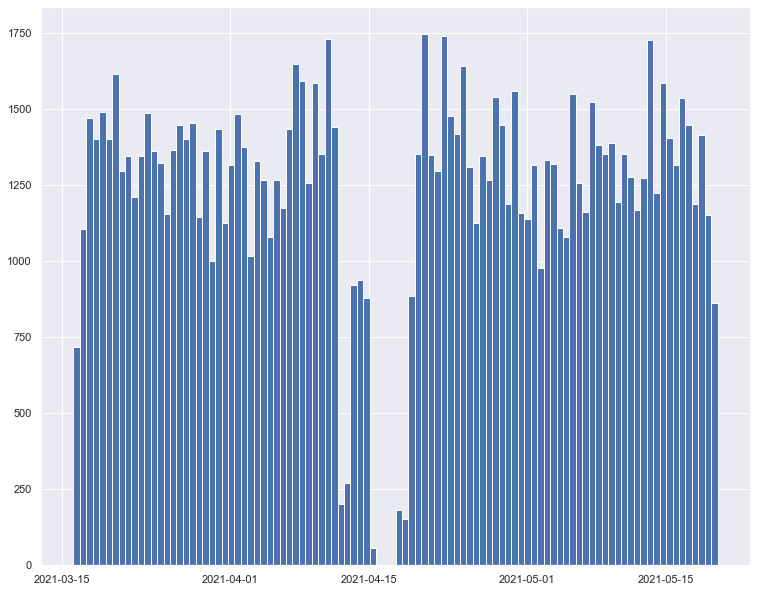

In [49]:
dff.operation_date[dff.target == 1].hist(bins=100)
plt.show()

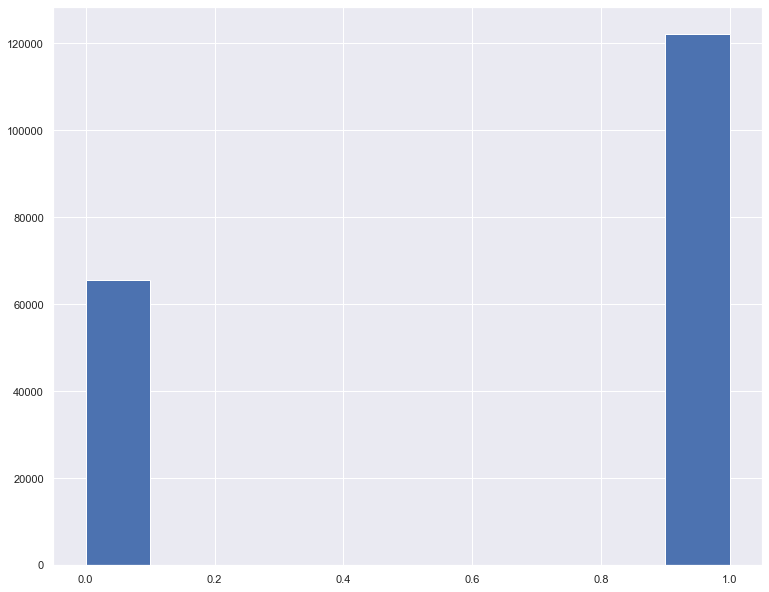

In [50]:
dff.target.fillna(0)[dff.operation_car == 2].hist()
plt.show()

In [51]:
"""
[Коментарии]
 Ниже видно, что станция операции и станция формирования поезда в некоторых случаях не совпадают
"""
dff[['operation_st_esr','destination_esr','index_train']][dff.target == 1]

,operation_st_esr,destination_esr,index_train
15360,944007,944609.00,944007360944609.00
15356,944007,944609.00,944007360944609.00
15371,944007,944609.00,944007360944609.00
15370,944007,944609.00,944007360944609.00
15361,944007,944609.00,944007360944609.00
...,...,...,...
1490184,967600,918801.00,967600870960007.00
1490187,967600,917207.00,967600870960007.00
1490138,967600,960103.00,967600870960007.00
1490137,967600,863806.00,967600870960007.00


#### Таблица с количеством интересующих операций отправления по парам станций из индекса поезда

Разбиваем данные на интервалы по 4 часа и считаем количество интересующих нас операций отправления.

In [52]:
def count_cars(df):
    pairs = {}
    counts = df.index_train[df.target == 1].value_counts()
    for count in counts.index: 
        src = str(int(count // 1e9))
        dst = str(int(count % 1e6))
        entry = src +'->'+dst 
        if entry in pairs:
            pairs[entry] += counts[count]
        else:
            pairs[entry] = counts[count]
    return pairs

In [53]:
tm_from = dff.operation_date.min()
full_tdf = pd.DataFrame()
while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    full_tdf = pd.concat([full_tdf,tdf], axis=1)

In [54]:
"""
[Коментарии]
  Датасет собирается по направлению "станция формирования поезда" -> "станция назначения"
"""
full_tdf.fillna(0,inplace=True)
full_tdf.head()

,2021-03-16 04:01:00,2021-03-16 08:01:00,2021-03-16 12:01:00,2021-03-16 16:01:00,2021-03-16 20:01:00,...,2021-05-19 12:01:00,2021-05-19 16:01:00,2021-05-19 20:01:00,2021-05-20 00:01:00,2021-05-20 04:01:00
944007->944609,0,60.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0
954704->950101,0,59.00,19.00,0.00,8.00,...,0.00,71.00,35.00,0.00,0
968707->960103,0,20.00,0.00,12.00,34.00,...,0.00,0.00,0.00,0.00,0
955406->950101,0,8.00,0.00,0.00,0.00,...,46.00,0.00,0.00,0.00,0
960007->970001,0,5.00,0.00,0.00,0.00,...,0.00,3.00,0.00,0.00,0


In [55]:
full_tdf

,2021-03-16 04:01:00,2021-03-16 08:01:00,2021-03-16 12:01:00,2021-03-16 16:01:00,2021-03-16 20:01:00,...,2021-05-19 12:01:00,2021-05-19 16:01:00,2021-05-19 20:01:00,2021-05-20 00:01:00,2021-05-20 04:01:00
944007->944609,0,60.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0
954704->950101,0,59.00,19.00,0.00,8.00,...,0.00,71.00,35.00,0.00,0
968707->960103,0,20.00,0.00,12.00,34.00,...,0.00,0.00,0.00,0.00,0
955406->950101,0,8.00,0.00,0.00,0.00,...,46.00,0.00,0.00,0.00,0
960007->970001,0,5.00,0.00,0.00,0.00,...,0.00,3.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
953006->952906,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0
972505->862108,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0
864902->970406,0,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0
917103->962804,0,0.00,0.00,0.00,0.00,...,0.00,4.00,0.00,0.00,0


#### Таблица по станции назначения поезда

In [56]:
def count_cars_dst(df):
    pairs = {}
    counts = df.index_train[df.target == 1].value_counts()
    for count in counts.index: 
        dst = str(int(count % 1e6)) 
        if dst in pairs:
            pairs[dst] += counts[count]
        else:
            pairs[dst] = counts[count]
    return pairs

tm_from = dff.operation_date.min()
full_tdf_dst = pd.DataFrame()
while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars_dst(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    full_tdf_dst = pd.concat([full_tdf_dst,tdf], axis=1)

In [57]:
"""
[Коментарии]
  Датасет собирается по станции назначения поезда.
"""
full_tdf_dst.fillna(0,inplace=True)
full_tdf_dst.head()

,2021-03-16 04:01:00,2021-03-16 08:01:00,2021-03-16 12:01:00,2021-03-16 16:01:00,2021-03-16 20:01:00,...,2021-05-19 12:01:00,2021-05-19 16:01:00,2021-05-19 20:01:00,2021-05-20 00:01:00,2021-05-20 04:01:00
944609,0,60.00,77.00,5.00,2.00,...,10.00,16.00,20.00,0.00,0
950101,0,67.00,20.00,3.00,14.00,...,55.00,73.00,83.00,0.00,0
960103,0,20.00,0.00,12.00,34.00,...,0.00,0.00,0.00,0.00,0
970001,0,5.00,0.00,0.00,0.00,...,4.00,3.00,6.00,0.00,0
960007,0,4.00,3.00,1.00,6.00,...,52.00,77.00,128.00,13.00,0


#### Таблица по станции операции

In [58]:
def count_cars_op(df):
    op_st_esr = {}
    counts = df.operation_st_esr[df.target == 1].value_counts()
    for count in counts.index: 
        st_esr = str(int(count)) 
        if st_esr in op_st_esr:
            op_st_esr[st_esr] += counts[count]
        else:
            op_st_esr[st_esr] = counts[count]
    return op_st_esr

tm_from = dff.operation_date.min()

full_tdf_op = pd.DataFrame()

while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars_op(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    full_tdf_op  = pd.concat([full_tdf_op,tdf], axis=1)

In [59]:
"""
[Коментарии]
  Датасет собирается по станции операции отправления.
"""
full_tdf_op.fillna(0,inplace=True)
full_tdf_op.head()

,2021-03-16 04:01:00,2021-03-16 08:01:00,2021-03-16 12:01:00,2021-03-16 16:01:00,2021-03-16 20:01:00,...,2021-05-19 12:01:00,2021-05-19 16:01:00,2021-05-19 20:01:00,2021-05-20 00:01:00,2021-05-20 04:01:00
944007,0,60.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0
954704,0,59.00,19.00,4.00,8.00,...,0.00,71.00,35.00,0.00,0
968707,0,20.00,0.00,12.00,34.00,...,0.00,60.00,63.00,0.00,0
955406,0,8.00,0.00,0.00,46.00,...,46.00,0.00,27.00,0.00,0
960007,0,5.00,4.00,28.00,3.00,...,12.00,3.00,20.00,0.00,0


### Baseline средствами XGBoost 

Использовалась следующая статья:  
https://machinelearningmastery.com/xgboost-for-time-series-forecasting/  

Задача анализа временного ряда трансформируется в задачу обучения с учителем.

In [60]:
"""
k - это номер ряда в одном из датасетов
full_tdf - датасет по направлениям
full_tdf_dst - датасет по станциям назначения
full_tdf_op - датасет по станциям операции
"""
k = 3 # 

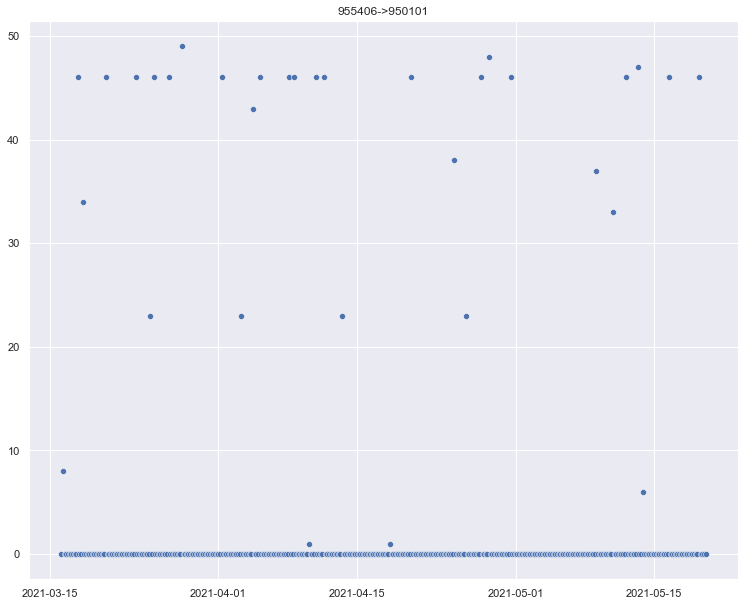

In [61]:
sns.scatterplot(y=full_tdf.iloc[k].values,x=full_tdf.iloc[k].keys(),data=full_tdf.iloc[k])
plt.title(full_tdf.index[k])
plt.show()

In [62]:
full_tdf.iloc[k]

2021-03-16 04:01:00    0.00
2021-03-16 08:01:00    8.00
2021-03-16 12:01:00    0.00
2021-03-16 16:01:00    0.00
2021-03-16 20:01:00    0.00
                       ... 
2021-05-19 12:01:00   46.00
2021-05-19 16:01:00    0.00
2021-05-19 20:01:00    0.00
2021-05-20 00:01:00    0.00
2021-05-20 04:01:00    0.00
Name: 955406->950101, Length: 391, dtype: float64

In [63]:
"""
[Коментарии]
 series_to_supervised() - переводит задачу анализа временных рядов в задачу обучения с учителем
 train_test_split() - разделение на train/test
 xgboost_forecast() - предсказание на шаг вперед
 walk_forward_validation() - пошаговая валидация
 predict_and_plot() - сделать предсказания и отобразить результаты
 
"""

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[0]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = max(0, np.round(model.predict(np.expand_dims(testX, axis=(0)))[0],0))
    return yhat

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in tqdm(range(len(test))):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
#         print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

def predict_and_plot(series,df,title):
    values = series.values
    # transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=4)

    # evaluate
    mae, y, yhat = walk_forward_validation(data, 50)
    print('MAE: %.3f' % mae)
    # plot expected vs preducted
    plt.plot(y, label='Expected')
    plt.plot(yhat, label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


MAE: 5.980


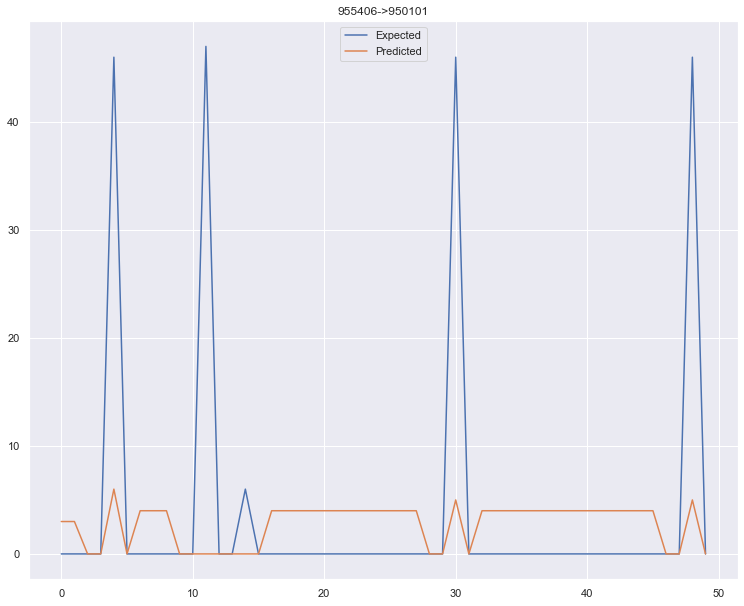

In [64]:
# датасет по направлениям
series = full_tdf.iloc[k]
predict_and_plot(series,full_tdf,full_tdf.index[k])

100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


MAE: 9.760


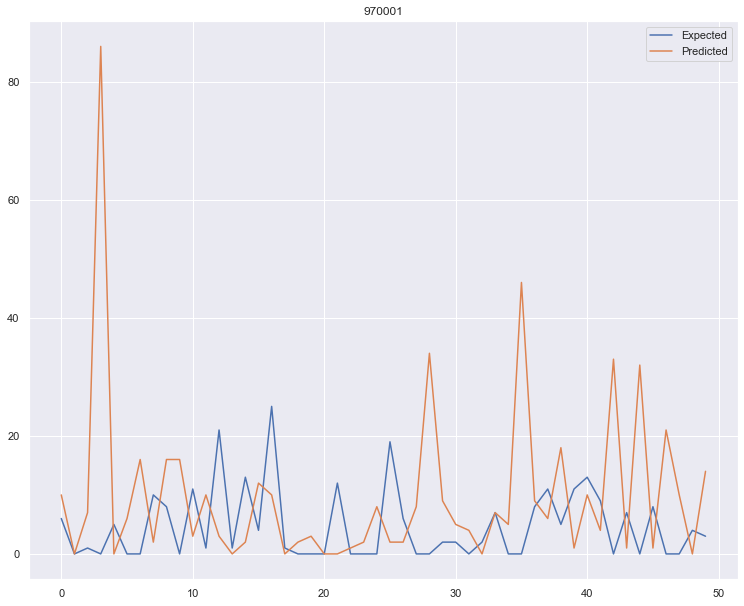

In [65]:
# датасет по станции назначения
series = full_tdf_dst.iloc[k]
predict_and_plot(series,full_tdf_dst,full_tdf_dst.index[k])

100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


MAE: 40.220


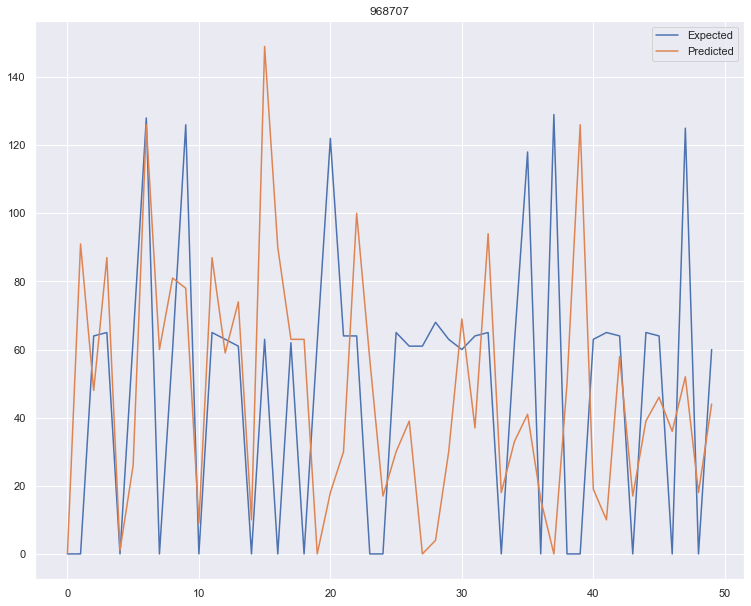

In [66]:
# Датасет по станции операции
series = full_tdf_op[full_tdf_op.index == '968707'].loc['968707']
predict_and_plot(series,full_tdf_op,st_id)

### Очистка исходного датасета, проверка гипотез

In [67]:
# выбираем только данные после провала 16-18 апреля
clean_df = ndf[ndf.operation_date > pd.Timestamp('2021-04-19 00:00:00')]
print(f'Размерность исходного датасета\t{ndf.shape}')
print(f'Размерность нового датасета\t{clean_df.shape}')

Размерность исходного датасета	(1501134, 44)
Размерность нового датасета	(749957, 44)


In [68]:
# выборка станций на которых была хотя бы одна операция отправления
print(f'Размерность датасета до очистки\t{clean_df.shape}')
clean_df = clean_df[clean_df.operation_st_esr.isin(clean_df.operation_st_esr[clean_df.operation_car == 2].unique())]
print(f'Размерность датасета после очистки\t{clean_df.shape}')

Размерность датасета до очистки	(749957, 44)
Размерность датасета после очистки	(714803, 44)


In [69]:
# выборка операций отправления
cx = get_list_of_indexes_with_success(clean_df, clean_df.car_number.unique())
# новый столбец с таргетом
clean_df = clean_df.assign(target=pd.Series(dtype=int))
# помечаем все найденные индексы 
clean_df['target'].loc[cx] = 1

100%|██████████| 74037/74037 [06:47<00:00, 181.80it/s]


In [70]:
# формирование таблицы с количеством вагонов
tm_from = clean_df.operation_date.min()
clean_tdf = pd.DataFrame()
while tm_from <= dff.operation_date.max() - pd.Timedelta(4,unit="hours"):
    tm_to = tm_from + pd.Timedelta(4,unit="hours")
    
    df_slice = clean_df[clean_df.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    tdf = pd.DataFrame.from_dict(count_cars(df_slice),orient='index',columns=[tm_to])
    tm_from = tm_to
    clean_tdf = pd.concat([clean_tdf,tdf], axis=1)

In [71]:
clean_tdf.fillna(0,inplace=True)

#### Предсказания на очищенном датасете

100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


MAE: 0.620


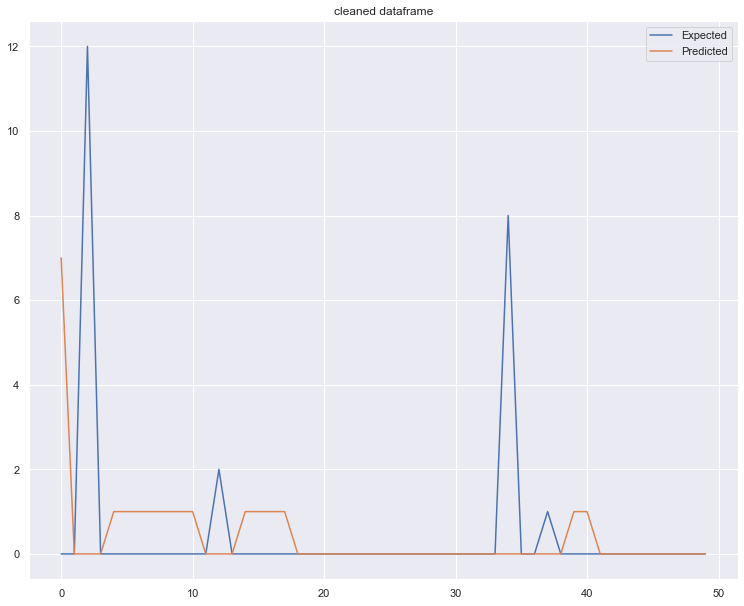

In [72]:
series = clean_tdf.iloc[k]
predict_and_plot(series,clean_tdf, 'cleaned dataframe')

#### Граф по наиболее нагруженным направлениям

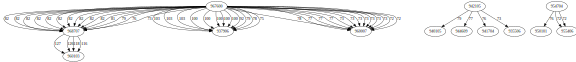

In [73]:
DG = Digraph(f'Top 100 trains by number of cars', filename='top_trains')
DG.attr(rankdir='TB', size='8,5')

c = clean_df.index_train[clean_df.target == 1].value_counts()

for i in range(50):
    src = str(c.index[i])[:6]
    dst = str(c.index[i])[9:-2]
    DG.edge(src, dst,label=f'{c.values[i]}')

DG

### Формирование дополнительного датасета по исходным параметрам по станции

При переводе данных в таблицу теряется много информации. Можно попробовать собрать эту информацию в отдельный датасет, чтобы использовать его для обучения моделей.

In [74]:
# исходный датасет
ndf.head()

,adm,car_number,danger,destination_esr,destination_id,...,following_mark,processing_road,junction,special_mark_1,dispatch_id
10633,20,63826424,NaN,913206.00,2000036356.00,...,0,96,NaN,0.00,2096ЭЦ783955
17633,20,94428141,NaN,950008.00,2000038022.00,...,0,94,0.00,NaN,NaN
10976,20,63885651,NaN,913206.00,2000036356.00,...,0,96,NaN,0.00,2096ЭЦ783948
12608,20,64485410,NaN,983514.00,2000038920.00,...,0,96,NaN,0.00,2096ЭЦ886266
9777,20,62898473,NaN,913206.00,2000036356.00,...,0,96,NaN,0.00,2096ЭЦ826997


In [75]:
ndf.columns

Index(['adm', 'car_number', 'danger', 'destination_esr', 'destination_id',
       'group_car', 'gruz', 'id', 'index_train', 'innovag', 'int_disl', 'kds',
       'kod_group', 'length', 'loaded', 'lves', 'number_train',
       'ont_time_write', 'operation_car', 'operation_date', 'operation_st_esr',
       'operation_st_id', 'operation_train', 'operator', 'park', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'stkgos_id', 'tare_weight', 'track', 'train_id', 'uns', 'weight',
       'weight_brutto', 'weight_netto', 'following_mark', 'processing_road',
       'junction', 'special_mark_1', 'dispatch_id'],
      dtype='object')

In [76]:
def build_series(df,st_id):

    ops = [21, 19, 11, 18, 20, 10, 28, 29]
    df = df[df.operation_st_esr == st_id]
    df_dict = {}

    df_dict['dang_cars_sent'] = df[df.danger == 1][df.operation_car == 2].shape[0]
    df_dict['inno_cars_sent'] = df.car_number[df.innovag == 1][df.operation_car == 2].nunique()
    df_dict['load_cars_sent'] = df[df.loaded == 1][df.operation_car == 2].shape[0]
    df_dict['empt_cars_sent'] = df[df.loaded == 2][df.operation_car == 2].shape[0]    
    for i in range(1,6):
        df_dict[f'grp{i}_cars_sent'] = df.car_number[df.kod_group == i][df.operation_car == 2].nunique()
    for i in range(1,10):
        df_dict[f'sp_mark_{i}_sent'] = df[df.special_mark_1 == i][df.operation_car == 2].shape[0]
        
    df_dict['sum_len_cars_sent'] = np.round(df.length[df.operation_car == 2].sum(),2)
    df_dict['sum_wgt_cars_sent'] = df.weight[df.operation_car == 2].sum() / 1000 # tonns
    
    # 40 - платформы, 41 - платформа 2х ярусная для перевозки автомобилей
    df_dict['platf_sent'] = df.car_number[df.rodvag.isin([40,41])][df.operation_car == 2].nunique()
    # 60 - полувагоны, 61 - полувагоны глуходонные
    df_dict['gcar_sent'] = df.car_number[df.rodvag.isin([60,61])][df.operation_car == 2].nunique()
    # 70 - цистерны
    df_dict['tanks_sent'] = df.car_number[df.rodvag.isin(np.arange(70,79))][df.operation_car == 2].nunique()
    # 20 - крытые
    df_dict['covrd_sent'] = df.car_number[df.rodvag.isin([20])][df.operation_car == 2].nunique()
    # 90 - прочие
    df_dict['oth_sent'] = df.car_number[df.rodvag.isin(np.arange(90,99))][df.operation_car == 2].nunique()
    # 80 - вагоны термоса, 81 - рефрижираторные
    df_dict['therm_sent'] = df.car_number[df.rodvag.isin(np.arange(80,81))][df.operation_car == 2].nunique()    


    df_dict['cars_num'] = df.car_number.nunique()
    df_dict['dest_esr_num'] = df.destination_esr.nunique()
    df_dict['gruz_codes_num'] = df.gruz.nunique()    
    
    df_dict['operators_num'] = df.operator.nunique()
    df_dict['senders_num'] = df.receiver.nunique()
    df_dict['recievers_num'] = df.sender.nunique()
    
    df_dict['train_types_num'] = df.rod_train[df.operation_car == 2].nunique()
    
    df_dict['tracks_used'] = df.track.nunique()
    
    # вагон следует на хранение
    df_dict['cars_to_storage'] = df[df.following_mark.isin([2,3])][df.operation_car == 2].shape[0]
        
    df_dict['dispatch_ids_num'] = df.dispatch_id.nunique()
    df_dict['ld_unld_ops_num'] = df[df.operation_car.isin(ops)].shape[0]    
    df_dict['cars_sent_after_ld_unld'] = df[df.target == 1].shape[0]
    return pd.Series(list(df_dict.values()),index=list(df_dict.keys()))

Список полей:

*dang_cars_sent* - количество отправленых вагонов отмеченных как опасные  
*inno_cars_sent* - количество отправленых вагонов отмеченных как инновационные  
*load_cars_sent* - количество отправленых вагонов груженых  
*empt_cars_sent* - количество отправленых вагонов порожних  
*grp{i}_cars_sent* - количество отправленных вагонов по признаку группы  
*sp_mark_{i}_sent* - количество отправленных вагонов по специальным отметкам  
*sum_len_cars_sent* - суммарная длина отправленых вагонов  
*sum_wgt_cars_sent* - суммарный вес отправленных вагонов  
*platf_sent* - количество отправленных платформ  
*gcar_sent* - количество отправленных полувагонов  
*tanks_sent* - количество отправленных цистерн  
*covrd_sent* - количество отправленных крытых вагонов  
*oth_sent* - количество отправленных прочих вагонов  
*therm_sent* - количество отправленных термовагонов  
*cars_num* - количество уникальных вагонов  
*dest_esr_num* - количество уникальных станций назначения  
*gruz_codes_num* - количество уникальных кодов груза  
*operators_num* - количество уникальных операторов   
*senders_num* - количество уникальных отправителей  
*recievers_num* - количество уникальных получателей  
*train_types_num* - количество уникальных типов поездов  
*tracks_used* - количество используемых путей  
*cars_to_storage* - количество вагонов отправленных на хранение   
*dispatch_ids_num* - уникальные диспетчерские номера  
*ld_unld_ops_num* - количество операций погрузки/выгрузки  
*cars_sent_after_ld_unld* - количество операций отправления погруженых/разгруженых вагонов  



In [77]:
# пример серии со сгенерированными полями
build_series(dff,st_id)

dang_cars_sent                  0.00
inno_cars_sent                 35.00
load_cars_sent              17259.00
empt_cars_sent                167.00
grp1_cars_sent                  0.00
grp2_cars_sent                  0.00
grp3_cars_sent                  0.00
grp4_cars_sent               8002.00
grp5_cars_sent               1931.00
sp_mark_1_sent                  0.00
sp_mark_2_sent               2104.00
sp_mark_3_sent               7015.00
sp_mark_4_sent               3279.00
sp_mark_5_sent               2901.00
sp_mark_6_sent                 27.00
sp_mark_7_sent                  0.00
sp_mark_8_sent                  0.00
sp_mark_9_sent                  0.00
sum_len_cars_sent           15081.44
sum_wgt_cars_sent         1073337.33
platf_sent                     19.00
gcar_sent                     219.00
tanks_sent                   9172.00
covrd_sent                     11.00
oth_sent                      131.00
therm_sent                      0.00
cars_num                    10670.00
d

Собирается датасет по станции заданной в переменной st_id:

In [78]:
tm_to = dff.operation_date.max()
kdf = pd.DataFrame()
while tm_to >= dff.operation_date.min() + pd.Timedelta(4,unit="hours"):
    tm_from = tm_to - pd.Timedelta(4,unit="hours")
    
    df_slice = dff[dff.operation_date > tm_from]
    df_slice = df_slice[df_slice.operation_date < tm_to]
    
    df_series = build_series(df_slice,st_id)
    tm_to = tm_from
    kdf  = pd.concat([df_series.to_frame(name=tm_to),kdf], axis=1)

In [79]:
print(f'Датасет по станции st_id = {st_id}')
kdft = kdf.T

Датасет по станции st_id = 968707


#### Добавление таргета

In [80]:
target = kdft.cars_sent_after_ld_unld.shift(-1)
esr_968707  = pd.concat([kdft[:-1],target[:-1].to_frame(name='target')], axis=1)

In [81]:
esr_968707

,dang_cars_sent,inno_cars_sent,load_cars_sent,empt_cars_sent,grp1_cars_sent,...,cars_to_storage,dispatch_ids_num,ld_unld_ops_num,cars_sent_after_ld_unld,target
2021-03-16 01:51:00,0.00,0.00,65.00,0.00,0.00,...,0.00,32.00,30.00,20.00,0.00
2021-03-16 05:51:00,0.00,0.00,0.00,0.00,0.00,...,0.00,19.00,47.00,0.00,0.00
2021-03-16 09:51:00,0.00,0.00,61.00,0.00,0.00,...,0.00,8.00,5.00,0.00,12.00
2021-03-16 13:51:00,0.00,5.00,61.00,5.00,0.00,...,0.00,22.00,34.00,12.00,34.00
2021-03-16 17:51:00,0.00,0.00,63.00,0.00,0.00,...,0.00,25.00,46.00,34.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-19 05:51:00,0.00,1.00,127.00,3.00,0.00,...,0.00,51.00,53.00,125.00,60.00
2021-05-19 09:51:00,0.00,0.00,60.00,0.00,0.00,...,0.00,39.00,87.00,60.00,63.00
2021-05-19 13:51:00,0.00,0.00,63.00,0.00,0.00,...,0.00,40.00,108.00,63.00,0.00
2021-05-19 17:51:00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00


### Обучение моделей и предсказания

#### Разделение на трейн/тест

In [82]:
esr_968707.shape[0] - 40 

350

In [83]:
train = esr_968707[:esr_968707.shape[0] - 40]
X_train = train.drop(columns=['target'])
y_train = train.target

test = esr_968707[esr_968707.shape[0] - 40:]
X_test = test.drop(columns=['target'])
y_test = test.target

#### XGboost defaults

In [84]:
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)

[17:09:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
y_pred = xgboost_model.predict(X_test)
predictions = [round(value) for value in y_pred]

MAE: 36.925


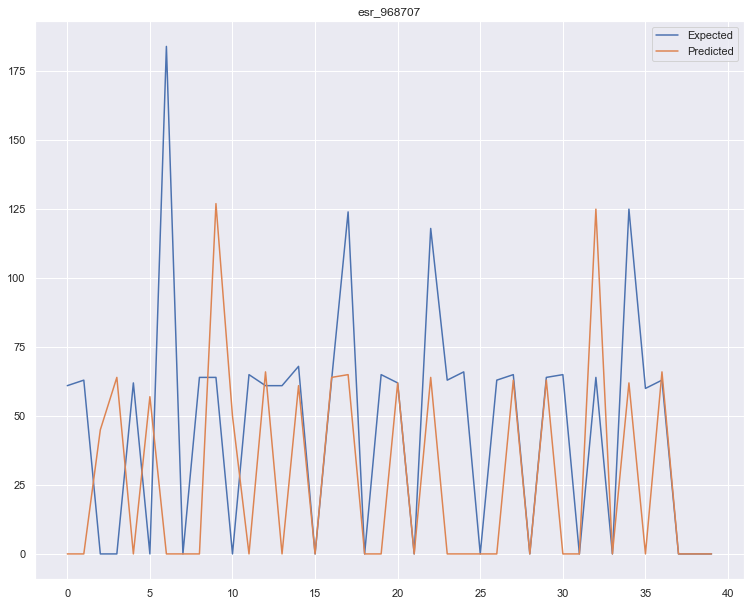

In [86]:
print('MAE: %.3f' % mean_absolute_error(y_test, predictions))
# plot expected vs preducted
plt.plot(y_test.values, label='Expected')
plt.plot(y_pred, label='Predicted')
plt.title('esr_968707')
plt.legend()
plt.show()

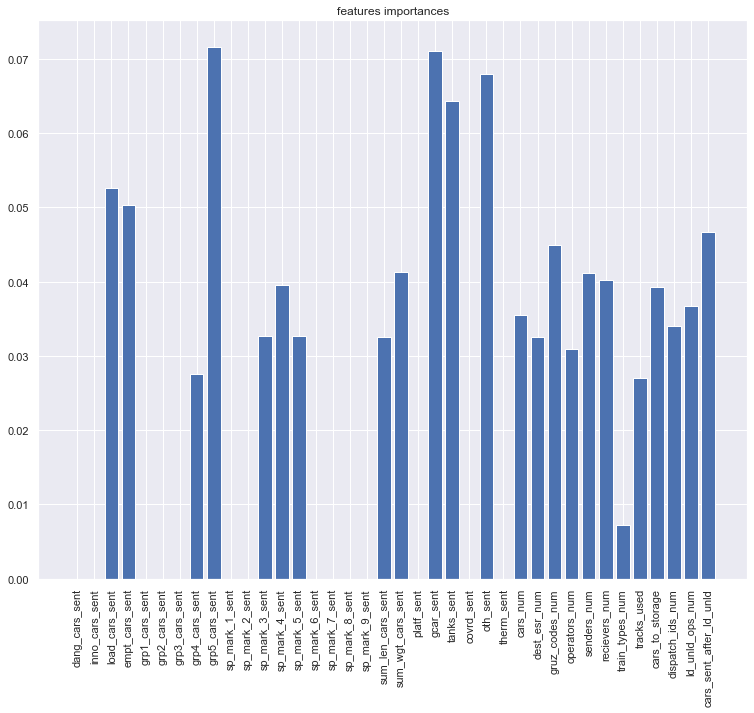

In [87]:
xxgb = esr_968707.columns[:-1]
yxgb = xgboost_model.feature_importances_
plt.bar(xxgb,yxgb)
plt.xticks(rotation=90)
plt.title('features importances')
plt.show()

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


MAE: 40.220


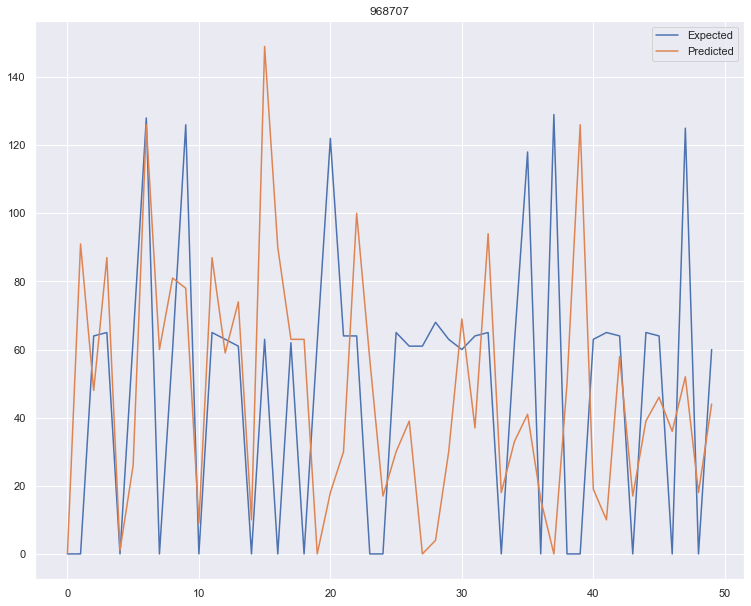

In [88]:
series = full_tdf_op[full_tdf_op.index == '968707'].loc['968707']
predict_and_plot(series,full_tdf_op,st_id)

#### CatBoost

In [89]:
model_catboost = CatBoostRegressor(iterations=3000,
                                   learning_rate=0.01,
                                   depth=10,
                                   verbose=0
                                  )

In [90]:
model_catboost.fit(X_train,y_train)

In [91]:
catb_pred = model_catboost.predict(X_test)

MAE: 35.800


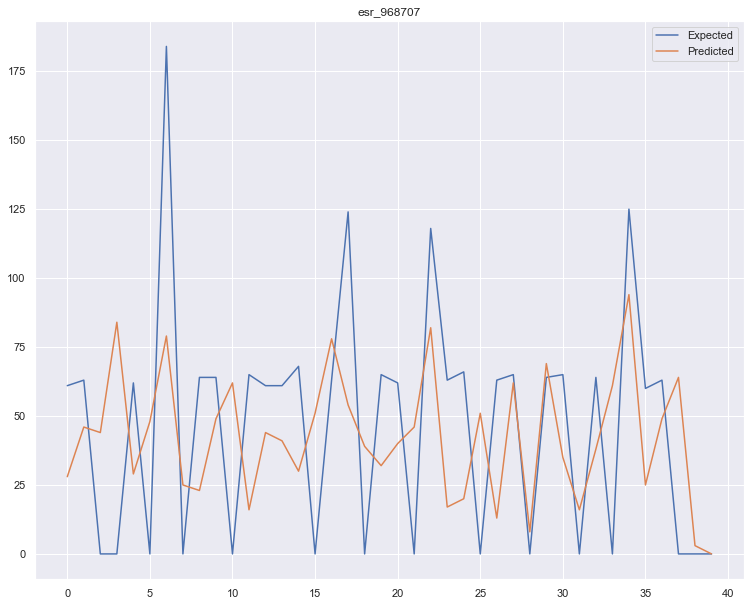

In [92]:
print('MAE: %.3f' % mean_absolute_error(y_test, catb_pred.astype(int)))
plt.plot(test.target.values, label = 'Expected')
plt.plot(catb_pred.astype(int), label = 'Predicted')
plt.title('esr_968707')
plt.legend()
plt.show()

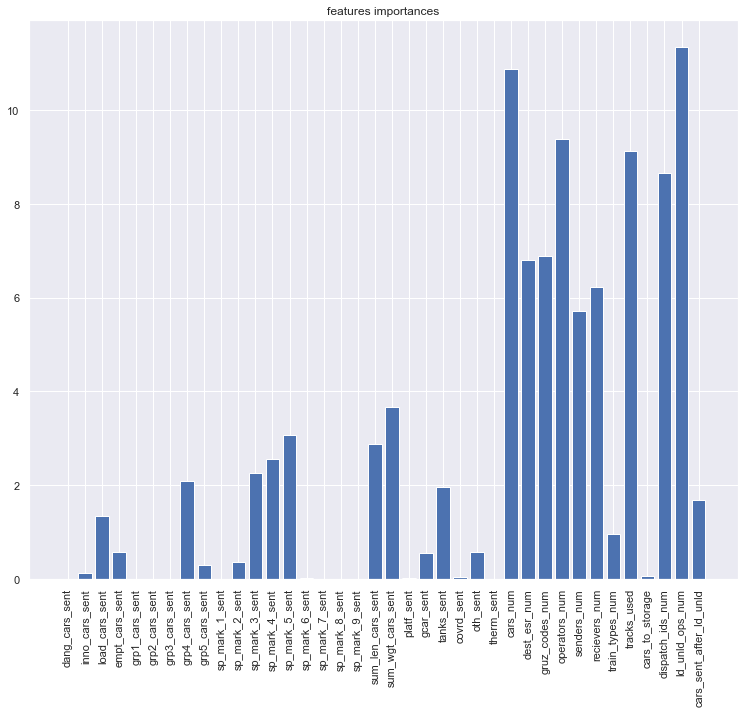

In [93]:
xcat = model_catboost.feature_names_
ycat = model_catboost.feature_importances_
plt.bar(xcat,ycat)
plt.xticks(rotation=90)
plt.title('features importances')
plt.show()

#### H2O XGBoost

In [94]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment AdoptOpenJDK-11.0.11+9 (build 11.0.11+9); OpenJDK 64-Bit Server VM AdoptOpenJDK-11.0.11+9 (build 11.0.11+9, mixed mode)
  Starting server from /usr/local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/46/n__pt5q101z9fpty0tfxds4m0000gn/T/tmp8uzy9f7r
  JVM stdout: /var/folders/46/n__pt5q101z9fpty0tfxds4m0000gn/T/tmp8uzy9f7r/h2o_kost_started_from_python.out
  JVM stderr: /var/folders/46/n__pt5q101z9fpty0tfxds4m0000gn/T/tmp8uzy9f7r/h2o_kost_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,"21 days, 23 hours and 10 minutes"
H2O_cluster_name:,H2O_from_python_kost_f5epn7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [95]:
h2o_model = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=42)

h2o_model.train(x=list(esr_968707.columns),
                  y="target",
                  training_frame=h2o.H2OFrame(train),
                  validation_frame=h2o.H2OFrame(test))

perf = h2o_model.model_performance(train=h2o.H2OFrame(train),valid=h2o.H2OFrame(test))


pred = h2o_model.predict(h2o.H2OFrame(test))

feature_interactions = h2o_model.feature_interaction()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [96]:
h2o_predict = pred.as_data_frame().values
h2o_predict = h2o_predict.reshape(h2o_predict.shape[0]).astype(int)
t =[]
for i in h2o_predict:
    t.append(max(0,i))
h2o_predict = np.array(t)

In [97]:
perf


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 5.819210140953674
RMSE: 2.412303907254157
MAE: 1.4570172125952585
RMSLE: NaN
Mean Residual Deviance: 5.819210140953674


MAE: 41.200


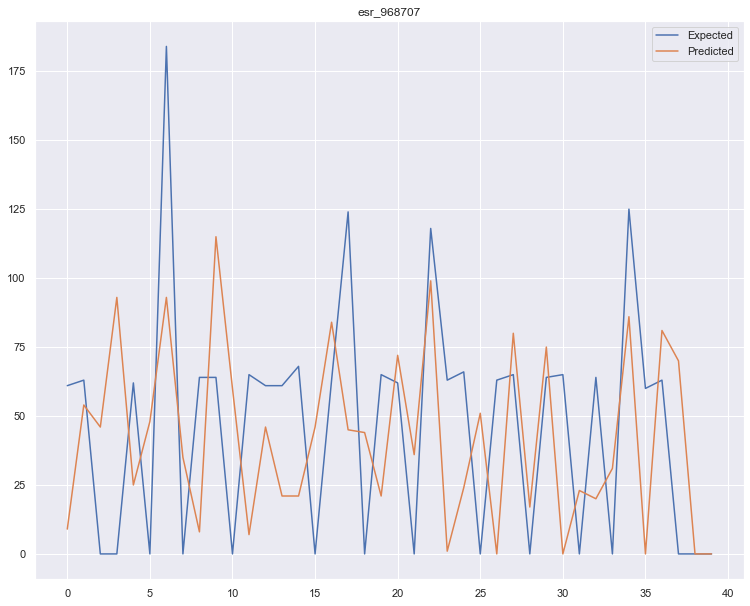

In [98]:
print('MAE: %.3f' % mean_absolute_error(y_test, h2o_predict))
plt.plot(test.target.values, label = 'Expected')
plt.plot(h2o_predict, label = 'Predicted')
plt.title('esr_968707')
plt.legend()
plt.show()

In [99]:
h2o_model.feature_frequencies

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1623334249340_1


Model Summary: 


,,number_of_trees
0,,50.00




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 5.819210140953674
RMSE: 2.412303907254157
MAE: 1.4570172125952585
RMSLE: NaN
Mean Residual Deviance: 5.819210140953674

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 2293.556921185792
RMSE: 47.8910943828369
MAE: 41.90988727584481
RMSLE: NaN
Mean Residual Deviance: 2293.556921185792

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-06-10 17:10:54,0.034 sec,0.00,60.68,41.59,3682.04,63.54,46.95,4036.70
1,,2021-06-10 17:10:55,0.157 sec,1.00,50.21,36.24,2521.35,54.16,42.78,2933.42
2,,2021-06-10 17:10:55,0.186 sec,2.00,42.34,31.30,1792.32,48.93,40.35,2394.54
3,,2021-06-10 17:10:55,0.203 sec,3.00,36.71,27.39,1347.62,45.71,39.21,2089.57
4,,2021-06-10 17:10:55,0.217 sec,4.00,31.70,23.81,1004.88,44.89,38.20,2015.08
5,,2021-06-10 17:10:55,0.232 sec,5.00,29.65,22.49,878.90,43.55,36.89,1896.59
6,,2021-06-10 17:10:55,0.243 sec,6.00,27.06,20.46,732.00,43.31,36.54,1875.56
7,,2021-06-10 17:10:55,0.253 sec,7.00,24.75,18.67,612.66,43.41,36.44,1884.14
8,,2021-06-10 17:10:55,0.263 sec,8.00,23.41,17.52,547.90,43.05,36.05,1852.96
9,,2021-06-10 17:10:55,0.275 sec,9.00,22.21,16.40,493.40,43.84,36.91,1922.18



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,cars_num,220176.55,1.00,0.18
1,ld_unld_ops_num,141845.53,0.64,0.11
2,dispatch_ids_num,121705.59,0.55,0.10
3,operators_num,115203.25,0.52,0.09
4,gruz_codes_num,63583.85,0.29,0.05
5,sp_mark_5_sent,62091.50,0.28,0.05
6,dest_esr_num,59089.65,0.27,0.05
7,tracks_used,58428.08,0.27,0.05
8,grp4_cars_sent,54520.23,0.25,0.04
9,senders_num,54340.18,0.25,0.04



See the whole table with table.as_data_frame()


<bound method ModelBase.feature_frequencies of >

In [101]:
print(f'Expct\tPred\tDelta')  
delta = []
for tst,pdct in zip(test.target.values,h2o_predict):  
    print(f'{int(tst)}\t{pdct}\t{pdct-int(tst)}')
    delta.append(pdct-int(tst))

Expct	Pred	Delta
61	9	-52
63	54	-9
0	46	46
0	93	93
62	25	-37
0	48	48
184	93	-91
0	35	35
64	8	-56
64	115	51
0	60	60
65	7	-58
61	46	-15
61	21	-40
68	21	-47
0	46	46
63	84	21
124	45	-79
0	44	44
65	21	-44
62	72	10
0	36	36
118	99	-19
63	1	-62
66	24	-42
0	51	51
63	0	-63
65	80	15
0	17	17
64	75	11
65	0	-65
0	23	23
64	20	-44
0	31	31
125	86	-39
60	0	-60
63	81	18
0	70	70
0	0	0
0	0	0


#### H2O AutoML

In [102]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=list(esr_968707.columns), y="target",
                  training_frame=h2o.H2OFrame(train),
                  validation_frame=h2o.H2OFrame(test))

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
17:11:33.723: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20210610_171133_model_2,1778.42,42.1713,1778.42,33.284,2.41211
StackedEnsemble_BestOfFamily_AutoML_20210610_171133,1800.36,42.4307,1800.36,33.3128,2.40612
StackedEnsemble_AllModels_AutoML_20210610_171133,1841.31,42.9105,1841.31,33.6481,2.4124
GBM_grid__1_AutoML_20210610_171133_model_1,1851.15,43.025,1851.15,33.1547,nan
GBM_2_AutoML_20210610_171133,1857.97,43.1042,1857.97,32.8514,nan
GBM_4_AutoML_20210610_171133,1861.59,43.1461,1861.59,33.2743,nan
GLM_1_AutoML_20210610_171133,1865.82,43.1952,1865.82,34.9038,2.46356
GBM_3_AutoML_20210610_171133,1897.47,43.56,1897.47,33.6548,2.34491
GBM_5_AutoML_20210610_171133,1912.45,43.7315,1912.45,35.8312,2.50541
GBM_1_AutoML_20210610_171133,1925.39,43.8792,1925.39,33.6943,nan


In [115]:
aml_predict = aml.leader.predict(h2o.H2OFrame(test))

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [116]:
aml_predict = aml_predict.as_data_frame().values
aml_predict = aml_predict.reshape(aml_predict.shape[0]).astype(int)
t =[]
for i in aml_predict:
    t.append(max(0,i))
aml_predict = np.array(t)

MAE: 35.925


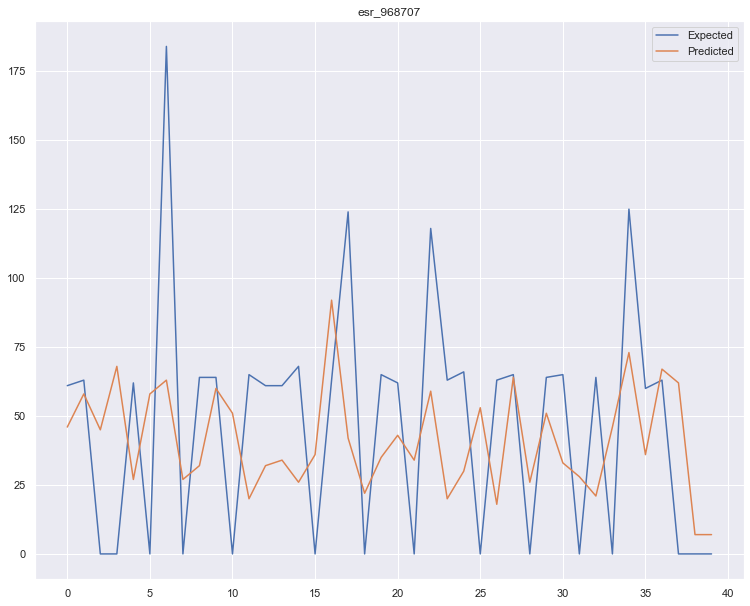

In [117]:
print('MAE: %.3f' % mean_absolute_error(y_test, aml_predict))
plt.plot(test.target.values, label = 'Expected')
plt.plot(aml_predict, label = 'Predicted')
plt.legend()
plt.title('esr_968707')
plt.show()

#### LSTM

In [106]:
def LSTM_probe(csv_path: str):
    """
    Reads 'csv_path' data, transforms it and 
    estimates LSTM model quality on first 6 directions.
    """

    df = pd.read_csv(csv_path, sep=';', index_col='index')[0:6].T

    print(f'Data_shape  = {df.shape}'     + '\n')
    print(f'Data_sample = \n {df.head()}' + '\n')

    def data_prep(data, n_steps_in):
        X, y = list(), list()
        for i in range(len(data)):
            end_idx     = n_steps_in + i
            out_end_idx = end_idx    + 1
            if out_end_idx > len(data):
                break
            seq_x, seq_y = data[i:end_idx,:], data[end_idx:out_end_idx,:]
            X.append(seq_x), y.append(seq_y)
        return np.array(X), np.array(y)

    WINDOW_SIZE = 3
    X, y = data_prep(df.to_numpy(), WINDOW_SIZE)

    FEATURES_NUM = X.shape[2]    
    print(f'X_shape  = {X.shape}')
    print(f'y_shape  = {y.shape}'      + '\n')
    print(f'Features = {FEATURES_NUM}' + '\n')

    def train_valid_split(X, y, frac=0.2):
        sep = int(len(X) * (1.0 - frac))

        X_train, y_train = X[:sep], y[:sep]
        X_valid, y_valid = X[sep:], y[sep:]
        
        return X_train, y_train, X_valid, y_valid

    X_train, \
    y_train, \
    X_valid, \
    y_valid = train_valid_split(X, y)

    def model_prep(inp_shape: tuple):
        model = Sequential([
            LSTM(20, activation='relu', input_shape=inp_shape),
            RepeatVector(1),
            LSTM(20, activation='relu', return_sequences=True),
            TimeDistributed(Dense(inp_shape[1])),
        ])
        return model

    model = model_prep([WINDOW_SIZE, FEATURES_NUM])
    model.compile(optimizer='adam', loss='mae')

    history = model.fit(
        X_train, 
        y_train,
        validation_data=(X_valid, y_valid),
        epochs=25,
        verbose=0)

    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('mae')
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid'], loc='upper left')
    
    y_predt = model.predict(X)
    
    ROWS, COLS = 2, 3
    __, ax = plt.subplots(nrows=ROWS, ncols=COLS)
    for i in range(ROWS):
        for j in range(COLS):
            ax[i][j].plot(y.T[i+j][0])
            ax[i][j].plot(np.maximum(0, y_predt.T[i+j][0]))
            ax[i][j].legend(['g_truth', 'predict'])

In [107]:
full_tdf.to_csv('full_tdf.csv',sep=';',index_label='index')

Data_shape  = (391, 6)

Data_sample = 
 index                944007->944609  954704->950101  968707->960103  \
2021-03-16 04:01:00            0.00            0.00            0.00   
2021-03-16 08:01:00           60.00           59.00           20.00   
2021-03-16 12:01:00            0.00           19.00            0.00   
2021-03-16 16:01:00            0.00            0.00           12.00   
2021-03-16 20:01:00            0.00            8.00           34.00   

index                955406->950101  960007->970001  930004->960007  
2021-03-16 04:01:00            0.00            0.00            0.00  
2021-03-16 08:01:00            8.00            5.00            4.00  
2021-03-16 12:01:00            0.00            0.00            0.00  
2021-03-16 16:01:00            0.00            0.00            0.00  
2021-03-16 20:01:00            0.00            0.00            0.00  

X_shape  = (388, 3, 6)
y_shape  = (388, 1, 6)

Features = 6



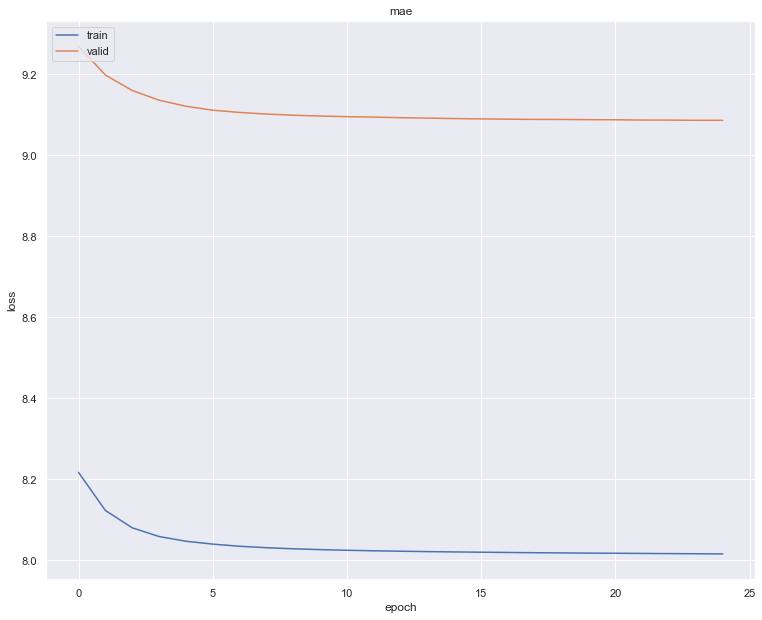

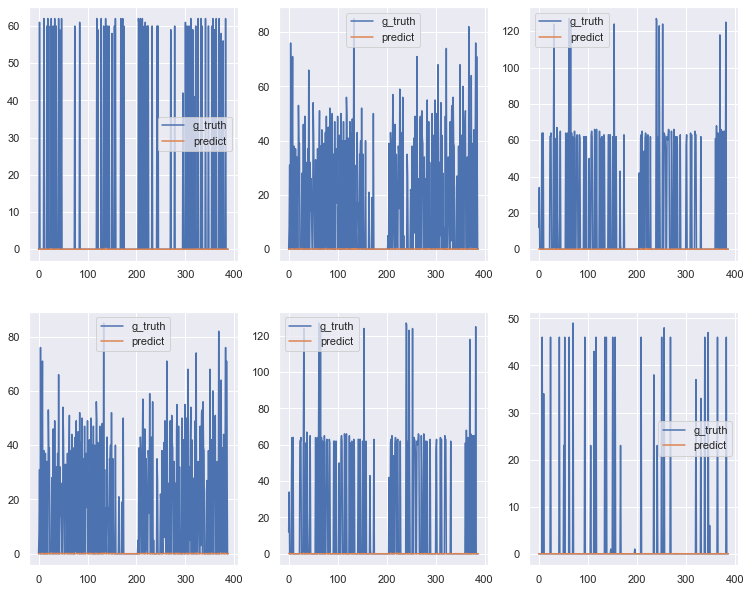

In [108]:
LSTM_probe('full_tdf.csv')

In [109]:
full_tdf_dst.to_csv('full_tdf_dst.csv',sep=';',index_label='index')

Data_shape  = (391, 6)

Data_sample = 
 index                944609  950101  960103  970001  960007  953701
2021-03-16 04:01:00    0.00    0.00    0.00    0.00    0.00    0.00
2021-03-16 08:01:00   60.00   67.00   20.00    5.00    4.00    3.00
2021-03-16 12:01:00   77.00   20.00    0.00    0.00    3.00   13.00
2021-03-16 16:01:00    5.00    3.00   12.00    0.00    1.00    0.00
2021-03-16 20:01:00    2.00   14.00   34.00    0.00    6.00    2.00

X_shape  = (388, 3, 6)
y_shape  = (388, 1, 6)

Features = 6



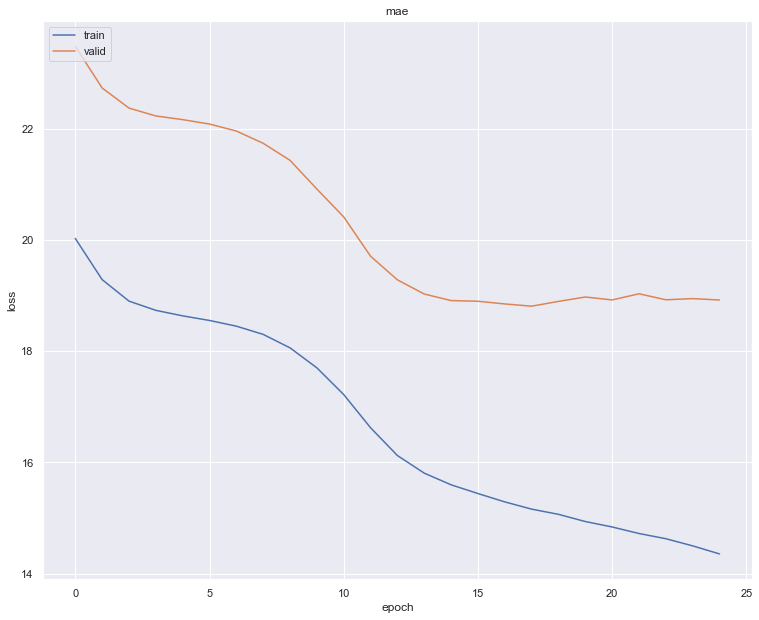

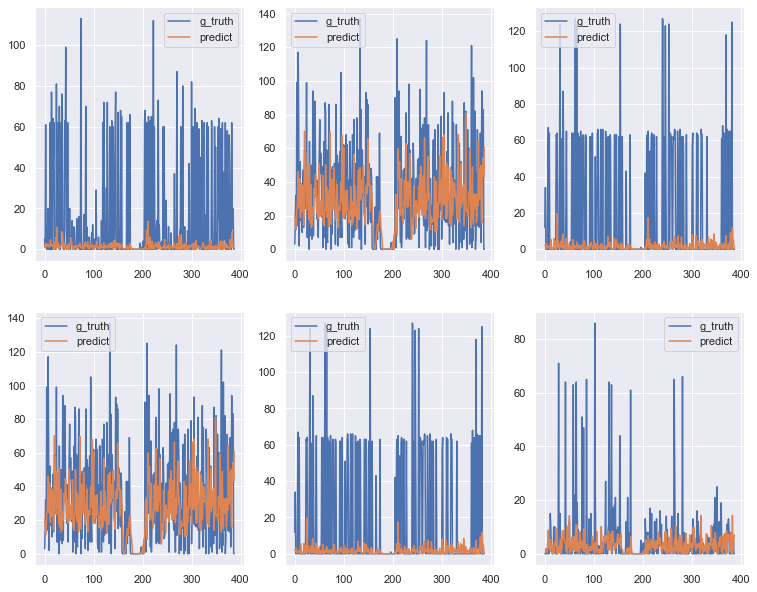

In [110]:
LSTM_probe('full_tdf_dst.csv')

In [111]:
full_tdf_op.to_csv('full_tdf_op.csv',sep=';',index_label='index')

Data_shape  = (391, 6)

Data_sample = 
 index                944007  954704  968707  955406  960007  963807
2021-03-16 04:01:00    0.00    0.00    0.00    0.00    0.00    0.00
2021-03-16 08:01:00   60.00   59.00   20.00    8.00    5.00    4.00
2021-03-16 12:01:00    1.00   19.00    0.00    0.00    4.00    5.00
2021-03-16 16:01:00    0.00    4.00   12.00    0.00   28.00    2.00
2021-03-16 20:01:00    0.00    8.00   34.00   46.00    3.00    0.00

X_shape  = (388, 3, 6)
y_shape  = (388, 1, 6)

Features = 6



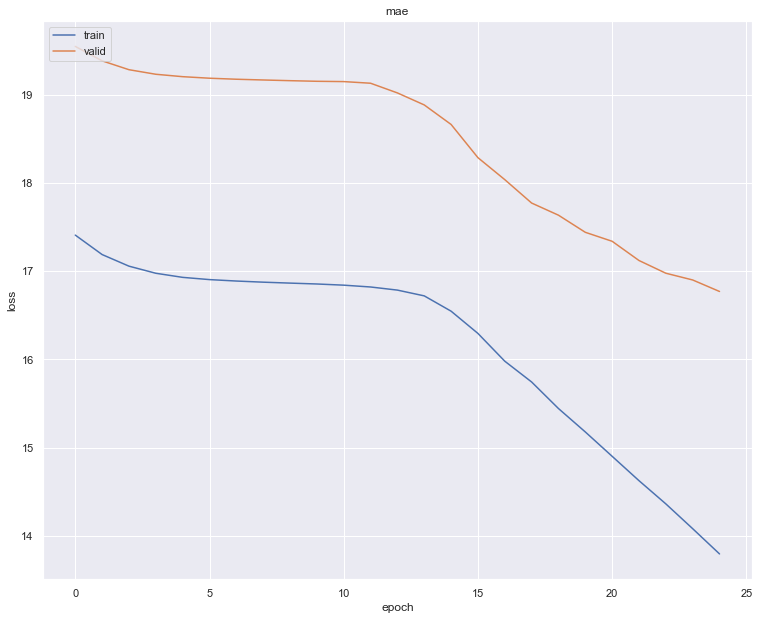

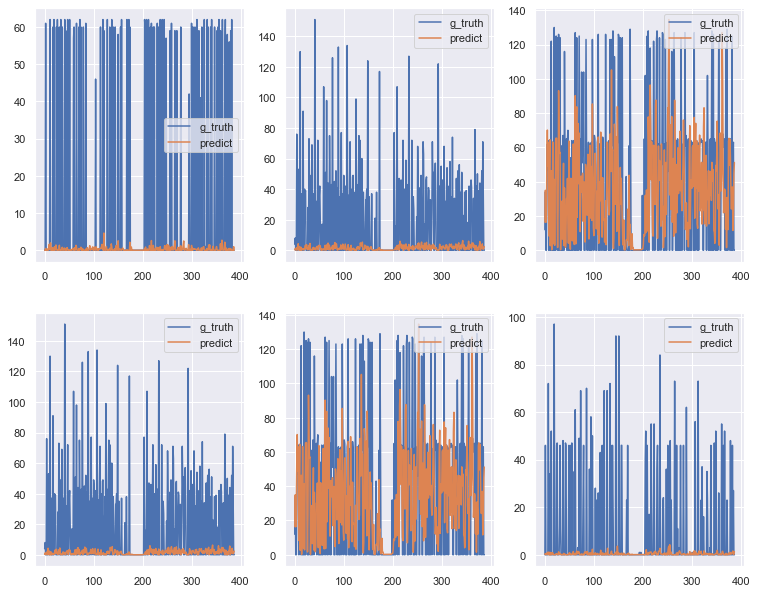

In [112]:
LSTM_probe('full_tdf_op.csv')

In [113]:
t1 = datetime.datetime.now()
print(f't0 = {t0.strftime("%H:%M:%S")}')
print(f't1 = {t1.strftime("%H:%M:%S")}')

t0 = 16:33:44
t1 = 17:13:41


In [114]:
with open(f'{PATH}/x.txt', 'w') as f:
    for item in x:
        f.write("%s\n" % item)

### Выводы